In [16]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

In [35]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = 1.0
USER_DISLIKED_ARTICLE = 0.0

def get_reward(context,action):
    if action == 'A':
        return USER_LIKED_ARTICLE
    else:
        return USER_DISLIKED_ARTICLE

        
        

# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    #example_string += "shared |Orga orga={} Cost_profile={}\n".format(context["orga"], context["cost_profile"])
    example_string += "shared |Orga orga={}\n".format(context["orga"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action variant={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [18]:
context = {"orga":"gov"}
actions = ["A", "B"]

print(to_vw_example_format(context,actions))

shared |Orga orga=gov
|Action variant=A 
|Action variant=B 


In [19]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob
        
        
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [27]:
################### Don't use ###################
orgas = ['gov', 'public']
#cost_profiles = ['relevant', 'irrelevant']
actions = ["A", "B"]

def choose_orga(self, orgas):
    return random.choice(orgas)

#def choose_cost_profile(cost_profiles):
#    return random.choice(times_of_day)

def generate_input_data(self):
    # start simulation 
    return


In [45]:
def run_simulation(vw, num_iterations, orgas, actions, reward_function, do_learn = True):
    reward_sum = 0.
    acc_reward = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        organisation = choose_orga(orgas)
        # 2. Choose time of day for a given user
        # Do not use for now
        #time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        #context = {'orga': user, 'cost_profile': time_of_day}
        context = {'orga': organisation}
        action, prob = get_action(vw, context, actions)

        # 4. Get reward of the action we chose
        reward = reward_function(context, action)
        reward_sum += reward

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, reward, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        acc_reward.append(reward_sum/i)

    return acc_reward

def plot_ctr(num_iterations, acc_reward):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

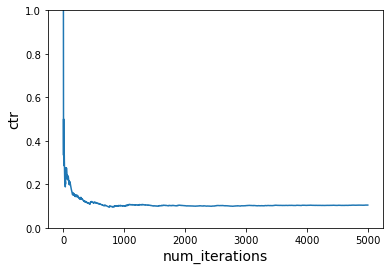

In [46]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, orgas, actions, get_reward)

plot_ctr(num_iterations, ctr)